# Raman Spectra Quality Control

## Setup

Import required packages

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from raman_lib.spectra_scoring import score_sort_spectra, score_names
from raman_lib.misc import load_data
from raman_lib.visualization import plot_spectra_peaks
from raman_lib.preprocessing import RangeLimiter, BaselineCorrector

Settings

In [3]:
# Name of the Dataset (for the output file)
name = "D3 Passages with PBMCs"

# Path where the data is stored
path = r"/proj/raman/Raman_Bernadette_out/A1 - D3 different passages with PBMCs/"

# Spectral range to analyze
# Use 'None' to use the whole range'
wn_min = None
wn_max = None

# QC settings - Choose either A or B and set the other to 'None'
# A)
n = 300 # How many spectra (per class) to keep (exactly this number - or less 
         # if a class does not contain enough spectra)
         
# B)
score_min = None # Minimum quality score that a spectrum must have to be kept.
n_min = None # Number of spectra that will be kept per class regardless of the score

# Window size for the Savitzky-Golay-Filter. Higher means stronger smoothing and less peaks found
sg_window = 50

# Threshold for the derivative. Higher means less peaks found.
threshold = 0.001

# Minimum height a peak must have to be detected
min_height = 50

# Plot baseline corrected (False) or raw spectra (True)
plot_raw = True

## Load Data

In [21]:
data = load_data(path)

print("Number of spectra per class:")
print(data.label.value_counts())

Number of spectra per class:
/proj/raman/Versuchsreihe_3_out/new    224
Name: label, dtype: int64


## Scoring and Spectra Selection

In [22]:
data_new, deriv, score_dict = score_sort_spectra(data, 
                                                 n=n,
                                                 min_score=score_min, 
                                                 min_n=n_min,
                                                 limits=(wn_min, wn_max), 
                                                 sg_window=sg_window, 
                                                 threshold=threshold, 
                                                 min_height=min_height,
                                                 score_measure=1,
                                                 n_peaks_influence=2,
                                                 detailed=True)

print()
print("====================================")
print()
print("Number of spectra per class (after QC):")
print(data_new.label.value_counts())

Analyzed 224 spectra in 4.25 seconds.
Mean Score: 177915

1st Quartile: 47380
Median Score: 97788
3rd Quartile: 236177

Min Score: 0
Max Score: 2677201


Number of spectra per class (after QC):
/proj/raman/Versuchsreihe_3_out/new    224
Name: label, dtype: int64


In [23]:
wns = data.drop(columns=["label", "file"]).columns
if plot_raw:
    data_plot = data.drop(columns=["label", "file"])
else:
    bl = BaselineCorrector()
    data_plot = bl.fit_transform(data.drop(columns=["label", "file"]))
    data_plot = pd.DataFrame(data_plot, columns=wns)

rl = RangeLimiter(lim=(wn_min, wn_max), 
                  reference=data_plot.columns)
data_plot = rl.fit_transform(data_plot)
wns_plot = data_plot.columns

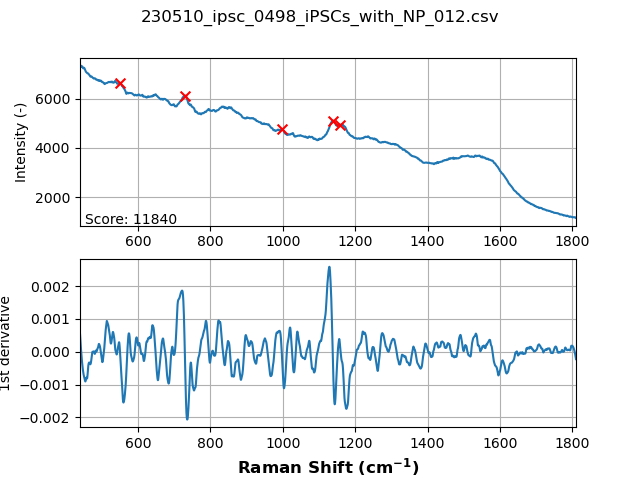

In [25]:
%matplotlib ipympl
plot_spectra_peaks(wns_plot, 
                   data_plot, 
                   deriv,
                   score_dict["peak_pos"],
                   score_dict["total_scores"],
                   labels=data.file)

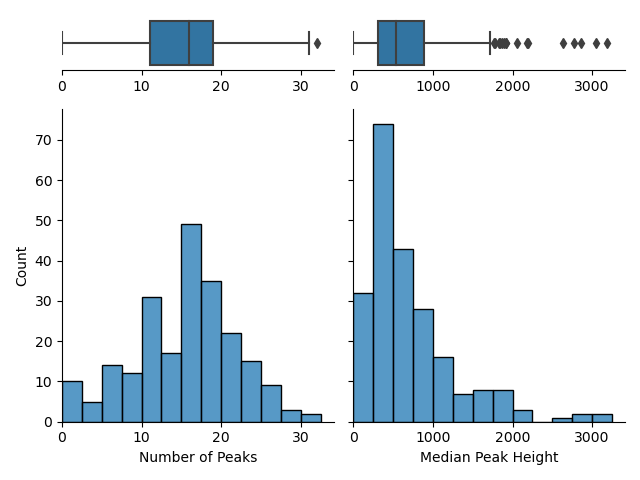

In [27]:
peak_lims = [0, None]
int_lims = [0, None]
y_lims = [None, None]

fig, ((ax_box1, ax_box2), (ax_hist1, ax_hist2)) = plt.subplots(
    2, 2, sharex="col", sharey="row", gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=score_dict["peak_scores"], ax=ax_box1)
sns.boxplot(x=score_dict["intensity_scores"], ax=ax_box2)
sns.histplot(score_dict["peak_scores"], ax=ax_hist1, binrange=None, binwidth=2.5)
sns.histplot(score_dict["intensity_scores"], ax=ax_hist2, binrange=None, binwidth=250)

ax_box1.set(yticks=[])
ax_box2.set(yticks=[])
sns.despine(ax=ax_hist1)
sns.despine(ax=ax_hist2)
sns.despine(ax=ax_box1, left=True)
sns.despine(ax=ax_box2, left=True)

ax_hist1.set_xlim(peak_lims)
ax_hist2.set_xlim(int_lims)

ax_hist1.set_ylim(y_lims)

ax_hist1.autoscale_view()
ax_hist2.autoscale_view()

ax_hist1.set_xlabel("Number of Peaks")
ax_hist2.set_xlabel("Median Peak Height")

ax_box1.tick_params(axis="x", labelbottom=True)
ax_box2.tick_params(axis="x", labelbottom=True)

fig.tight_layout()

## Export selected spectra

In [17]:
filename = name.lower().replace(" ", "_") + ".csv"

if not os.path.exists("./results_qc/"):
    os.mkdir("./results_qc/")

data_new.to_csv(os.path.join("./results_qc/", filename), index=False)